# โหลด Library ที่ถูกต้องเพื่อใช้งาน

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

!pip install --no-cache-dir "numpy<2" scikit-surprise

from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# โหลดข้อมูลจาก Kaggle โดยตรง


In [ ]:
import kagglehub

path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'the-movies-dataset' dataset.
Path to dataset files: /kaggle/input/the-movies-dataset


# โหลดข้อมูลเข้า memory ด้วย pandas

In [ ]:
!ls /root/.cache/kagglehub/datasets/rounakbanik/the-movies-dataset/versions/7


ls: cannot access '/root/.cache/kagglehub/datasets/rounakbanik/the-movies-dataset/versions/7': No such file or directory


In [ ]:
ratings = pd.read_csv(path + "/ratings.csv")

# Preprocessing Data



In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
ratings = ratings.drop(columns=["timestamp"])

In [ ]:
print(f"Size: {ratings.size:,}\n")
print(f"Null: \n{ratings.isnull().sum()}")
dupes = ratings.duplicated(subset=['userId','movieId']).sum()
print(f"\nDuplicate rows: {dupes}")
print(f"\nMissing values:\n {ratings.isna().sum()}")

Size: 78,072,867

Null: 
userId     0
movieId    0
rating     0
dtype: int64

Duplicate rows: 0

Missing values:
 userId     0
movieId    0
rating     0
dtype: int64


In [ ]:
ratings['userId']  = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)
ratings['rating']  = (ratings['rating']).astype(float)

In [ ]:
movie_counts = ratings['movieId'].value_counts()
user_counts = ratings['userId'].value_counts()

In [ ]:
user_counts.head(1000)

,count
userId,
45811,18276
8659,9279
270123,7638
179792,7515
228291,7410
...,...
189112,1407
73497,1407
215864,1407


In [ ]:
movie_counts.head(50000)

,count
movieId,
356,91921
318,91082
296,87901
593,84078
2571,77960
...,...
175753,1
175513,1
174821,1


# Box Plot และ Histogram ของ ข้อมูล ก่อนที่จะนำข้อมูลบางส่วนออก

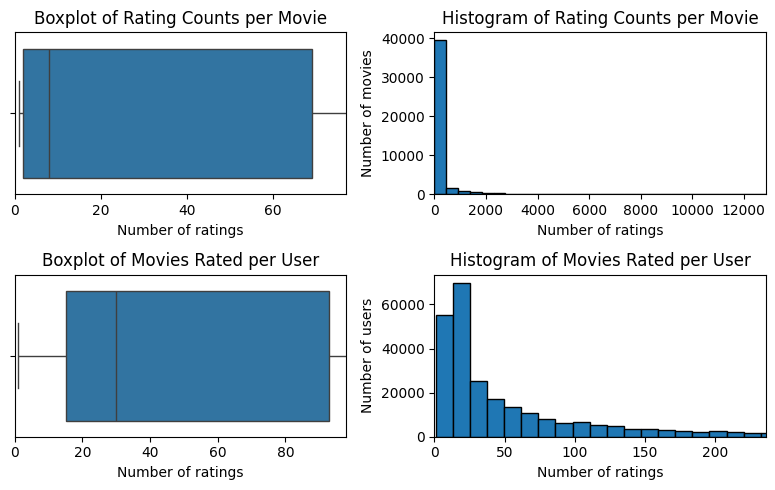

In [ ]:
plt.figure(figsize=(8, 5))

plt.subplot(2, 2, 1)
sns.boxplot(x=movie_counts)
plt.xlim(0, movie_counts.quantile(0.76))
plt.title("Boxplot of Rating Counts per Movie")
plt.xlabel("Number of ratings")

plt.subplot(2, 2, 2)
plt.hist(movie_counts, bins=200, edgecolor='black')
plt.xlim(0, movie_counts.quantile(0.99))
plt.title("Histogram of Rating Counts per Movie")
plt.xlabel("Number of ratings")
plt.ylabel("Number of movies")

plt.subplot(2, 2, 3)
sns.boxplot(x=user_counts)
plt.xlim(0, user_counts.quantile(0.76))
plt.title("Boxplot of Movies Rated per User")
plt.xlabel("Number of ratings")

plt.subplot(2, 2, 4)
plt.hist(user_counts, bins=1500, edgecolor='black')
plt.xlim(0, user_counts.quantile(0.9))
plt.title("Histogram of Movies Rated per User")
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")

plt.tight_layout()
plt.show()


# Scatter Plot ก่อนที่จะนำข้อมูลบางส่วนออก

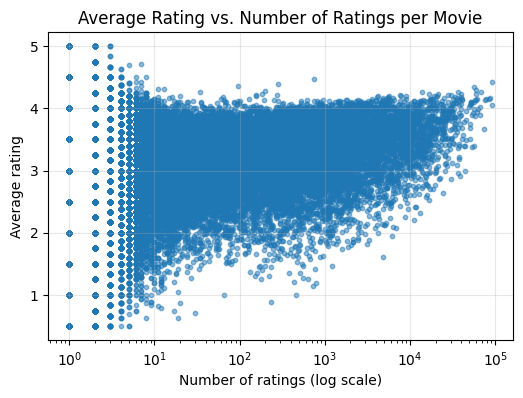

In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()

plt.figure(figsize=(6,4))
plt.scatter(movie_stats['count'], movie_stats['mean'], alpha=0.5, s=10)
plt.xscale('log')
plt.title("Average Rating vs. Number of Ratings per Movie")
plt.xlabel("Number of ratings (log scale)")
plt.ylabel("Average rating")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
corr_pearson = movie_stats['count'].corr(movie_stats['mean'], method='pearson')
print("Pearson correlation:", corr_pearson)


Pearson correlation: 0.12124607340899156


In [ ]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
num_ratings = len(ratings)

sparsity = 1 - num_ratings / (num_users * num_movies)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.9979


# เหตุผลที่นำข้อมูลออกบางส่วน

มีการกรองผู้ใช้ที่ให้คะแนนน้อยกว่า 10 หรือมากกว่า 300 เรื่องออก เพื่อกำจัดผู้ใช้ที่ไม่แสดงรสนิยมอย่างชัดเจนและผู้ใช้ที่มีลักษณะคล้ายนักวิจารณ์ ซึ่งอาจทำให้โมเดลเอนเอียง นอกจากนี้ยังตัดภาพยนตร์ที่มีคะแนนน้อยกว่า 10 ครั้งออกเพื่อลดความคลาดเคลื่อนของค่าเฉลี่ย ผลลัพธ์คือชุดข้อมูลที่มีความหนาแน่นและมีความเสถียรมากขึ้น เนื่องจากเป้าหมายหลักของการทำ model นี้ คือการแนะนำหนังให้กับ คนธรรมดาที่มได้มีการ rate หนังแบบ critic แต่ว่าที่ยังคง critic บางส่วนเอาไว้อยู่มีเหตุผลคือ ต้องการให้ข้อมูลนั้นมีความหน้าแน่นขึ้น เพื่อเพิ่ม accuracy ของ model

## จำนวนหนัง และ ผู้ชมที่ได้ทำการให้คะแนนหนังก่อนถูกนำออก

In [ ]:
num_movies = ratings['movieId'].nunique()
print("Before removing noise, Movies count:", num_movies)
num_users = ratings['userId'].nunique()
print("Before removing noise, Users count:", num_users)

Before removing noise, Movies count: 45115
Before removing noise, Users count: 270896


## Process ของการนำข้อมูลออก

In [ ]:
filtered_users = user_counts[user_counts <= 300].index
ratings = ratings[ratings['userId'].isin(filtered_users)]

filtered_users = user_counts[10 <= user_counts].index
ratings = ratings[ratings['userId'].isin(filtered_users)]

filtered_movies = movie_counts[movie_counts >= 10].index
ratings = ratings[ratings['movieId'].isin(filtered_movies)]
ratings.size

39648828

## จำนวนหนัง และ ผู้ชมที่ได้ทำการให้คะแนนหนังก่อนถูกนำออก

In [ ]:
num_movies = ratings['movieId'].nunique()
print("Before removing noise, Movies count:", num_movies)
num_users = ratings['userId'].nunique()
print("Before removing noise, Users count:", num_users)

Before removing noise, Movies count: 20016
Before removing noise, Users count: 213770


# Box Plot และ Histogram ของ ข้อมูล หลังจะนำข้อมูลบางส่วนออก

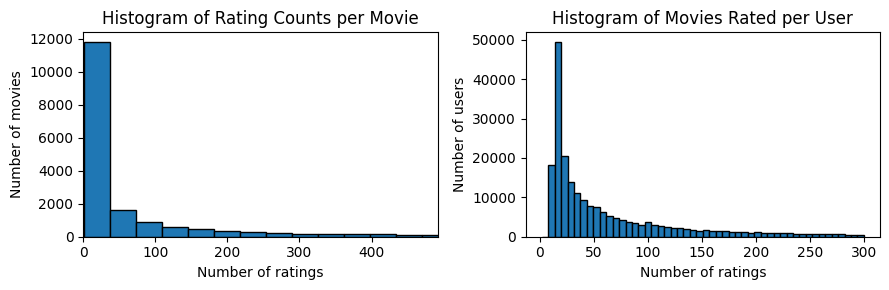

In [ ]:
movie_counts = ratings['movieId'].value_counts()
user_counts = ratings['userId'].value_counts()

plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.hist(movie_counts, bins=2000, edgecolor='black')
plt.xlim(0, movie_counts.quantile(0.85))
plt.title("Histogram of Rating Counts per Movie")
plt.xlabel("Number of ratings")
plt.ylabel("Number of movies")

plt.subplot(1, 2, 2)
plt.hist(user_counts, bins=50, edgecolor='black')
plt.title("Histogram of Movies Rated per User")
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")

plt.tight_layout()
plt.show()


# Scatter plot หลังนำข้อมูลบางส่วนออก

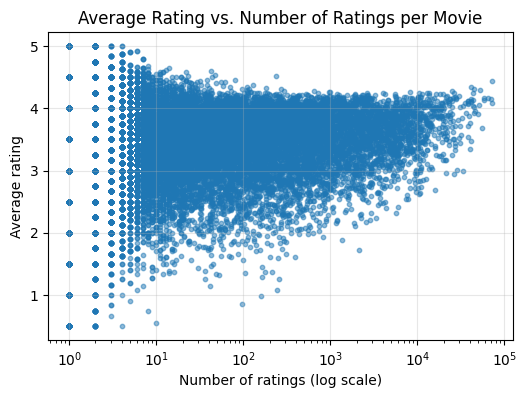

In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()

plt.figure(figsize=(6,4))
plt.scatter(movie_stats['count'], movie_stats['mean'], alpha=0.5, s=10)
plt.xscale('log')
plt.title("Average Rating vs. Number of Ratings per Movie")
plt.xlabel("Number of ratings (log scale)")
plt.ylabel("Average rating")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
corr_pearson = movie_stats['count'].corr(movie_stats['mean'], method='pearson')
print("Pearson correlation:", corr_pearson)


Pearson correlation: 0.07292632956299752


In [ ]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
num_ratings = len(ratings)

sparsity = 1 - num_ratings / (num_users * num_movies)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.9969


In [ ]:
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [ ]:
ratings['rating'].describe()

,rating
count,1.321628e+07
mean,3.662376e+00
std,1.061571e+00
min,5.000000e-01
25%,3.000000e+00
50%,4.000000e+00
75%,4.500000e+00
max,5.000000e+00


# Training Model

In [ ]:
trainset, testset = train_test_split(Dataset.load_from_df(ratings, Reader(rating_scale=(0.5, 5))), test_size=0.2, random_state=666)

In [ ]:
algo = SVD(n_factors=40, n_epochs=30, lr_all=0.005, reg_all=0.04, random_state=666)
algo.fit(trainset)

train_preds = algo.test(trainset.build_testset())
test_preds = algo.test(testset)

print("Train RMSE:", accuracy.rmse(train_preds, verbose=False))
print("Test RMSE:", accuracy.rmse(test_preds, verbose=False))

Train RMSE: 0.7552092276197896
Test RMSE: 0.8490015812027587


In [ ]:
ts = algo.trainset
probe = [1,260,480,356,364,1721,858,318]
hits = [(i, ts.knows_item(str(i)) or ts.knows_item(i)) for i in probe]
print("Per-ID presence:", hits, "hit_count=", sum(h for _,h in hits))

Per-ID presence: [(1, True), (260, True), (480, True), (356, True), (364, True), (1721, True), (858, True), (318, True)] hit_count= 8


In [ ]:
def fold_in_user(algo, user_ratings, lr=0.01, reg=0.02, steps=40):
    ts = algo.trainset
    mu, qi, bi = ts.global_mean, algo.qi, algo.bi
    k = qi.shape[1]
    pairs = []
    for i, r in user_ratings:
        if ts.knows_item(str(i)):
            ii = ts.to_inner_iid(str(i))
            pairs.append((ii, float(r)))
        elif ts.knows_item(i):
            ii = ts.to_inner_iid(i)
            pairs.append((ii, float(r)))
    p_u = np.zeros(k, dtype=np.float64)
    b_u = 0.0
    for _ in range(steps):
        for ii, r in pairs:
            err = r - (mu + b_u + bi[ii] + np.dot(p_u, qi[ii]))
            b_u += lr*(err - reg*b_u)
            p_u += lr*(err*qi[ii] - reg*p_u)
    return p_u, b_u, {ii for ii, _ in pairs}

def recommend_for_new_user(algo, p_u, b_u, exclude_inner_iids=None, topn=10, clip=True):
    ts = algo.trainset
    mu = ts.global_mean
    qi = algo.qi
    bi = algo.bi
    est = mu + b_u + bi + (qi @ p_u)
    if clip:
        lo, hi = ts.rating_scale
        est = np.clip(est, lo, hi)
    if exclude_inner_iids:
        mask = np.ones(qi.shape[0], dtype=bool)
        mask[list(exclude_inner_iids)] = False
        cand = np.where(mask)[0]
        scores = est[mask]
    else:
        cand = np.arange(qi.shape[0])
        scores = est
    if len(cand) <= topn:
        top_idx = np.argsort(scores)[::-1]
    else:
        top_idx = np.argpartition(scores, -topn)[-topn:]
        top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]
    inner_iids = cand[top_idx]
    raw_iids = [ts.to_raw_iid(int(ii)) for ii in inner_iids]

    return pd.DataFrame({"movieId": raw_iids, "predicted_rating": est[inner_iids]})

In [ ]:
from google.colab import files

links = pd.read_csv(path + "/links.csv")

uploaded = files.upload()
fname = next(iter(uploaded.keys()))

df = pd.read_csv(fname, encoding="utf-8-sig", low_memory=False)

c = 1_000_000
movie_ids = [1,260,480,356,364,1721,858,318]
all_rows = []

for i in range(10):
    user_id = c + i
    for m in movie_ids:
        rating = np.random.uniform(0.5, 5.0)  # random rating
        all_rows.append([user_id, m, round(rating, 1)])

df = pd.DataFrame(all_rows, columns=["userId", "movieId", "rating"])
print(df.head(20))

Saving collect_user.csv to collect_user (1).csv
     userId  movieId  rating
0   1000000        1     1.3
1   1000000      260     2.8
2   1000000      480     4.1
3   1000000      356     1.8
4   1000000      364     2.5
5   1000000     1721     0.9
6   1000000      858     2.7
7   1000000      318     3.8
8   1000001        1     2.2
9   1000001      260     1.0
10  1000001      480     1.9
11  1000001      356     4.6
12  1000001      364     0.8
13  1000001     1721     1.4
14  1000001      858     4.8
15  1000001      318     3.0
16  1000002        1     3.7
17  1000002      260     4.7
18  1000002      480     1.9
19  1000002      356     3.2


In [ ]:
movies = pd.read_csv(path + "/movies_metadata.csv")
movies = movies[["id","original_title"]]

/tmp/ipython-input-3464724729.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv(path + "/movies_metadata.csv")


In [ ]:
from tabulate import tabulate

unique_users = df["userId"].unique()

links = pd.read_csv(path + "/links.csv")
movies["id"] = pd.to_numeric(movies["id"], errors="coerce").astype("Int64")
movies = movies.merge(links, left_on="id", right_on="tmdbId", how="inner")

for uid in unique_users:
    u = df[df.userId==uid][["movieId","rating"]]
    user_ratings = list(zip(u.movieId, u.rating))
    p_u, b_u, seen = fold_in_user(algo, user_ratings, steps=40, lr=0.01, reg=0.02)
    recs = recommend_for_new_user(algo, p_u, b_u, exclude_inner_iids=seen, topn=20, clip=True)
    recs = recs.merge(movies, left_on="movieId", right_on="movieId", how="inner")[["movieId","predicted_rating","original_title"]]

    print(f"\nUser {uid}")
    print(tabulate(recs.head(10), headers="keys", tablefmt="pretty", showindex=False))



User 1000000
+---------+--------------------+---------------------------+
| movieId |  predicted_rating  |      original_title       |
+---------+--------------------+---------------------------+
| 134796  | 3.935047316988663  |        Bitter Lake        |
|  38320  | 3.8472954397605044 |   Valerie a týden divů    |
|  26453  | 3.7598725031859104 |      Smiley's People      |
|  72142  | 3.676160628256145  |       愛のむきだし        |
| 116411  | 3.6285807473570393 |        Mandariinid        |
|  51312  | 3.605008619342198  | Le conseguenze dell'amore |
|  7327   | 3.601237829387488  |          Persona          |
|  26875  | 3.5922037954004917 |    Una pura formalità     |
|  48165  | 3.589918304315537  |  Der siebente Kontinent   |
|  51455  | 3.5897723752986677 |   God Grew Tired of Us    |
+---------+--------------------+---------------------------+

User 1000001
+---------+--------------------+---------------------------------+
| movieId |  predicted_rating  |         original_title  